## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/"My Drive"/CVND/CVND_projects/P1_Facial_Keypoints

/content/drive/My Drive/CVND/CVND_projects/P1_Facial_Keypoints


In [3]:
!ls

'1. Load and Visualize Data.ipynb'			  images
'2. Define the Network Architecture.ipynb'		  LICENSE
'3. Facial Keypoint Detection, Complete Pipeline.ipynb'   models.py
'4. Fun with Keypoints.ipynb'				  __pycache__
 data							  README.md
 data_load.py						  requirements.txt
 detector_architectures					  saved_models


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

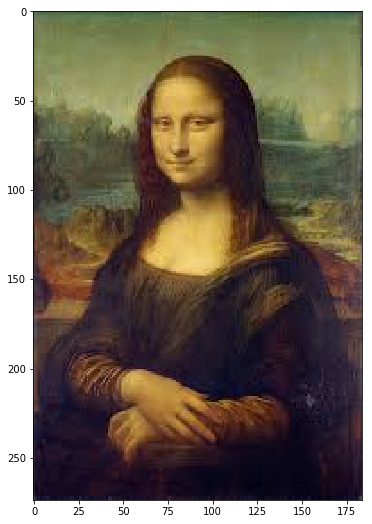

In [54]:
import cv2
# load in color image for face detection
image = cv2.imread('images/mona_lisa.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='https://drive.google.com/uc?id=1qT-nBqxWUXz2fz0NLcPZlG7Alc5VXW2g' width=80% height=80%/>


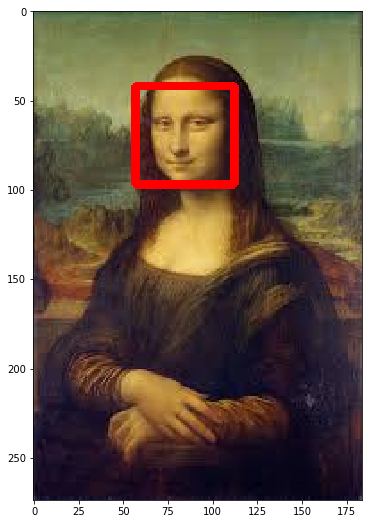

In [55]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [61]:
import torch
from models import NaimishNet

net = NaimishNet()
model_name = 'NaimishNet-100epochs_w_lr_decay.pt'
path = torch.load(f'saved_models/{model_name}')

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(path['model_state_dict'])

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

FileNotFoundError: ignored

In [57]:
!ls saved_models

NaimishNet-100epochs.pt  NaimishNet-100epochs_w_lr_decay_2.pt


## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='https://drive.google.com/uc?id=1q57o7xu10h12qxtP0KXU0FQg9ZteAzmE' width=30% height=30%/>




In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')



In [0]:
image_copy = np.copy(image)
from torch.autograd import Variable

# loop over the detected faces from your haar cascade
net.eval()
def disp(faces):
  for i, (x,y,w,h) in enumerate(faces):
      # Select the region of interest that is the face in the image 
      roi = image_copy[y:y+h, x:x+w]
      h, w = roi.shape[:2]
      roi_copy = roi.copy()

      ## TODO: Convert the face region from RGB to grayscale
      roi_copy = cv2.cvtColor(roi_copy, cv2.COLOR_BGR2GRAY)

      ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
      roi_copy= roi_copy/255.0

      ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
      roi_copy = cv2.resize(roi_copy, (224, 224))
      new_h, new_w = roi_copy.shape[:2]
      roi_copy = roi_copy[np.newaxis, :, :, np.newaxis]

      ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
      roi_copy = roi_copy.transpose((0, 3, 1, 2))
      roi_copy = torch.from_numpy(roi_copy)


      ## TODO: Make facial keypoint predictions using your loaded, trained network 
      ## perform a forward pass to get the predicted facial keypoints
      roi_copy = roi_copy.type(torch.FloatTensor)

      key_pts = net(Variable(roi_copy, volatile=True))
      key_pts = key_pts.view(68, 2)  
      key_pts = key_pts.data.numpy()
      key_pts = (key_pts*50.0)+100.0
      key_pts = key_pts * [float(h/new_h), float(w/new_w)]

      ## TODO: Display each detected face and the corresponding keypoints        

      plt.figure(figsize=(10, 8))
      if (i == 0):
          plt.subplot(2, 1, 1)
          show_all_keypoints(roi, key_pts)
      elif (i==1):
          plt.subplot(2, 1, 2)
          show_all_keypoints(roi, key_pts)
      plt.show()    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


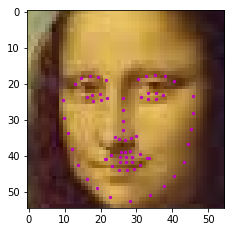

In [60]:
disp(faces)


In [0]:
model_dir = 'saved_models/'
model_name = 'NaimishNet-100epochs.pt'

torch.save(net.state_dict(), model_dir+model_name)
